In [1]:
import matplotlib
# import matplotlib.cm as cm
# from matplotlib.colors import Normalize
# from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
# mark_inset)
# %matplotlib inline
# matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
import numpy as np
# from numpy import isclose
from dolfin import *
# import matplotlib.pyplot as plt
from multiphenics import *

# import dolfin
# import multiphenics
# import matplotlib

# print(np.__version__) # 1.19.5
# print(matplotlib.__version__) # 3.0.3
# print(dolfin.__version__)# 2019.2.0.dev0

# Goal
?

In [2]:
# Some global parameters
tol = DOLFIN_EPS
degree = 2

sigma = 1
L = 1. # mesh size

In [3]:
mesh_name = 'EEG'
mesh = Mesh(mesh_name+".xml")
subdomains = MeshFunction("size_t", mesh, mesh_name+"_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, mesh_name+"_facet_region.xml")
File(mesh_name+"_mesh.pvd") << boundaries

N=11 # number of contacts
cnt_id=27 # contacts id begin from this number

In [4]:
dx = Measure("dx")(subdomain_data=subdomains)
ds = Measure("ds")(subdomain_data=boundaries)
# dS = Measure("dS")(subdomain_data=boundaries)
n = FacetNormal(mesh)

In [28]:
V = FunctionSpace(mesh, "Lagrange", degree)
R = FunctionSpace(mesh, "R", 0) # global constant
W = BlockFunctionSpace([V]+[R]*(N))#, restrict=[None]+ contacts)

u_mix = BlockTrialFunction(W)
v_mix = BlockTestFunction(W)

# order: contact1, contact2, ...
u_spl = block_split(u_mix)
v_spl = block_split(v_mix)

z= 1e-9

# RHS
a_00 = inner(sigma*grad(u_spl[0]), grad(v_spl[0]))*dx
for i in range(N):
    a_00 += dot(u_spl[0],v_spl[0])/z*ds(i+cnt_id)
a_0n = [-dot(u_spl[0], v_spl[i+1])/z*ds(i+cnt_id) for i in range(N)]
a_n0 = [-dot(u_spl[i+1], v_spl[0])/z*ds(i+cnt_id) for i in range(N)]
a_nn = [+dot(u_spl[i+1], v_spl[i+1])/z*ds(i+cnt_id) for i in range(N)]


a = np.zeros((N+1,N+1), dtype=type(a_00))
np.fill_diagonal(a, [a_00]+a_nn)
a[0,1:] = a_0n
a[1:,0] = a_n0 
a = a.tolist()

# LHS
f= Expression("sin(x[0]+x[1])", element=V.ufl_element())
I= [ Constant(0) for i in range(N) ]
DL = [assemble(dot(n,n)*ds(i+cnt_id)) for i in range(N)] # actual contact length

b= [ f*v_spl[0]*dx ] + [ I[i]*v_spl[i+1]/DL[i]*ds(i+cnt_id) for i in range(N)]

# BC
exotic_bc = Expression("(1+(1+x[0])*(1+x[0]))", degree=3)
bc0 = DirichletBC(W.sub(0), exotic_bc ,boundaries, 1) # left
bc1 = DirichletBC(W.sub(0), exotic_bc, boundaries, 2) # right
bc2 = DirichletBC(W.sub(0), exotic_bc, boundaries, 4) # bottom

bcs = BlockDirichletBC([[bc0, bc1]]+[[]]*N)

In [29]:
# SOLVE #
A = block_assemble(a)
B = block_assemble(b)

bcs.apply(A)
bcs.apply(B)

U = BlockFunction(W)
block_solve(A, U.block_vector(), B)

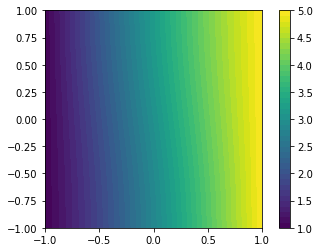

In [30]:
m =plot(U[0])
plt.colorbar(m)
plt.show()
File('sol_'+mesh_name+'.pvd') << U[0]

In [27]:
# sanity checks
# comp_currs = []
for i in range(cnt_id+N):
    I = assemble(-sigma*dot(grad(U[0]), n)*ds(i))
    l = assemble(dot(n, n)*ds(i))
    print('Current at border {} = {} \t length = {}'.format(i, I, l))

for i in range(cnt_id,cnt_id+N):
    I = assemble((U[0]-U[i+1-cnt_id])/z*ds(i))
    print('Current at contact {} = {}'.format(i, I))

Current at border 0 = 0.011189100729891124 	 length = 0.39999999999999986
Current at border 1 = 15.73542411588917 	 length = 2.0
Current at border 2 = -14.073069417182484 	 length = 2.0
Current at border 3 = -0.8662535509437671 	 length = 2.0
Current at border 4 = 0.0 	 length = 0.0
Current at border 5 = -1.9635353989977813 	 length = 1.4900000000000007
Current at border 6 = 0.0 	 length = 0.0
Current at border 7 = 0.0 	 length = 0.0
Current at border 8 = 0.0 	 length = 0.0
Current at border 9 = 0.0 	 length = 0.0
Current at border 10 = 0.0 	 length = 0.0
Current at border 11 = 0.0 	 length = 0.0
Current at border 12 = 0.0 	 length = 0.0
Current at border 13 = 0.0 	 length = 0.0
Current at border 14 = 0.0 	 length = 0.0
Current at border 15 = 0.0 	 length = 0.0
Current at border 16 = 0.0 	 length = 0.0
Current at border 17 = 0.0 	 length = 0.0
Current at border 18 = 0.0 	 length = 0.0
Current at border 19 = 0.0 	 length = 0.0
Current at border 20 = 0.0 	 length = 0.0
Current at border 

In [9]:
U[1].vector().vec()[:]

array([4.23103422])

In [10]:
# sanity checks
# comp_currs = []
for i in range(N):
    I = assemble(-sigma*dot(grad(U[0]), n)*ds(i+cnt_id))
    print('Current at contact {} = {}'.format(i, I))

Current at contact 0 = 6.72771579927637e-05
Current at contact 1 = 0.00027805590744967175
Current at contact 2 = -0.0003849296540947495
Current at contact 3 = -0.00041702558852324545
Current at contact 4 = -0.0010399199887239853
Current at contact 5 = 0.00037355371468687456
Current at contact 6 = -0.000950954454713824
Current at contact 7 = 0.00016356074857934726
Current at contact 8 = 0.0001852812763175574
Current at contact 9 = -0.0028123241733584063
Current at contact 10 = 0.0013179202786218114


In [11]:
info(parameters,True)

In [12]:
for p in parameters:
    print(p,'\t\t',parameters[p])

allow_extrapolation 		 False
dof_ordering_library 		 SCOTCH
form_compiler 		 <dolfin.cpp.parameter.Parameters object at 0x7f4eec23cc38>
ghost_mode 		 none
graph_coloring_library 		 Boost
krylov_solver 		 <dolfin.cpp.parameter.Parameters object at 0x7f4eec23cc38>
linear_algebra_backend 		 PETSc
lu_solver 		 <dolfin.cpp.parameter.Parameters object at 0x7f4eec23cc38>
mesh_partitioner 		 SCOTCH
partitioning_approach 		 PARTITION
print_mpi_thread_support_level 		 False
refinement_algorithm 		 plaza
relative_line_width 		 0.025
reorder_cells_gps 		 False
reorder_dofs_serial 		 True
reorder_vertices_gps 		 False
std_out_all_processes 		 True
timer_prefix 		 
use_petsc_signal_handler 		 False
warn_on_xml_file_size 		 100


In [13]:
for sol in U:
    q = sol
    print(q.vector().vec().min(), q.vector().vec().max())

(26614, -2.8734860697821105) (16732, 10.724360691283524)
(0, 4.231034218625472) (0, 4.231034218625472)
(0, 4.294785118263007) (0, 4.294785118263007)
(0, 4.3680363086128215) (0, 4.3680363086128215)
(0, 4.450633441012825) (0, 4.450633441012825)
(0, 4.54258884188337) (0, 4.54258884188337)
(0, 4.643994926935608) (0, 4.643994926935608)
(0, 4.755080795474503) (0, 4.755080795474503)
(0, 4.876097965654364) (0, 4.876097965654364)
(0, 5.007411700561942) (0, 5.007411700561942)
(0, 5.149532770226716) (0, 5.149532770226716)
(0, 5.302427077220687) (0, 5.302427077220687)


In [14]:
q.vector().vec().min(), q.vector().vec().max()

((0, 5.302427077220687), (0, 5.302427077220687))

In [15]:
qq= U[0].vector().vec()#.shape()

In [16]:
qq.array_w

array([5.00741171, 5.00741171, 5.00741174, ..., 4.45063344, 4.45036222,
       4.45063344])

In [17]:
qq.assemble()

In [18]:
A00= assemble(a_00)
A00.array()

array([[ 5.02769513e+04,  6.28373256e+03,  6.28373256e+03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 6.28373256e+03,  2.83848783e+04, -3.14201341e+03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 6.28373256e+03, -3.14201341e+03,  2.25143771e+04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         6.32602299e+04,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  4.70947025e+00, -6.23400841e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00, -6.23400841e-01,  5.02768947e+04]])

In [19]:
q= U.sub(1)

In [20]:
qv = q.vector()

In [21]:
qv.vec()[:]

array([4.23103422])

In [22]:
len(qv)

1

In [23]:
W.split()

AttributeError: 'BlockFunctionSpace' object has no attribute 'split'

In [ ]:
mesh = UnitSquareMesh(20,20)
subdomains = MeshFunction("size_t", mesh, mesh.topology().dim(), mesh.domains())
boundaries = MeshFunction('size_t', mesh, mesh.topology().dim()-1, 0)

left = Left(); left.mark(boundaries, 1)
right = Right(); right.mark(boundaries,2)
bottom = Bottom();  bottom.mark(boundaries, 3)
hole = Hole(); hole.mark(boundaries, 4)
File('boundaries.pvd') << boundaries

dx = Measure("dx")(subdomain_data=subdomains)
ds = Measure("ds")(subdomain_data=boundaries)
dS = Measure("dS")(subdomain_data=boundaries)
n = FacetNormal(mesh)

for i in range(5):
    print(assemble(dot(n,n)*ds(i)))
    
10*0.2 + 16*sqrt(2)*0.2/4